# pyphysio tutorial

## 2. Algorithms

In this second tutorial we will see how to use the class `Algorithm` to create signal processing pipelines.


A signal processing step is a computational function $F$ that operates on input data (a signal) to produce a result. It is characterized by a set of parameters **p** which regulate its behavior.

![algorithm](img/algorithm.png)

*Figure 1: Abstract representation of a processing step.*

1. In pyphysio each processing step is represented by an instance of a class derived from the generic class `Algorithm`.

2. The type of function or algorithm is given by the class name (e.g. `BeatFromECG` extracts the heartbeats from an ECG signal, `PeakDetection` detects the peaks in the input signal).

3. The parameters of the function/algorithm are the attributes of the created instance.

Therefore, a processing step is defined by creating a new instance of the Class, which is initialized with the given parameters:
```
processing_step = ph.BeatFromECG(parameters)
```
To execute the processing step we need to give as input an instance of the class `Signal`:
```
output = processing_step(input)
```


Algorithms in pyphysio are grouped in four categories (see also the tutorial '3-pipelines'):

* Filters : deterministic algorithms that modify the values of the input signal without changing its nature;
* Estimators : algorithms that aim at extracting information from the input signal which is given in output as a signal with a different nature;
* Indicators : algorithms that operate on the signal to provide a scalar value (or metrics)
* Tools : algorithms that can be useful for the signal processing and return as output one or more numpy arrays or scalars.

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# import data from included examples
from pyphysio import TestData
from pyphysio import create_signal

ecg_data = TestData.ecg()
eda_data = TestData.eda()

# create two signals
fsamp = 2048
tstart_ecg = 15
tstart_eda = 5

ecg = create_signal(data = ecg_data, sampling_freq = fsamp, start_time = tstart_ecg)

eda = create_signal(data = eda_data, sampling_freq = fsamp, start_time = tstart_eda)

Using dask. Scheduler: threads
Please cite:
Bizzego et al. (2019) 'pyphysio: A physiological signal processing library for data science approaches in physiology', SoftwareX


### 2.1 Filters

Filters return a signal of the same *"type"* of the input signal. 

The name *`Filters`* recalls the aim of this algorithms which is in general to increase the Signal/Noise ratio by filtering out the unwanted components in a signal (e.g high frequency noise).

In [3]:
# create a Filter
import pyphysio.filters as flt

lowpass_50 = flt.IIRFilter(fp=50, fs=75, ftype='ellip')

In [4]:
# help inline
#?flt.IIRFilter

In [5]:
# check parameters
print(lowpass_50)
# OR
print(lowpass_50.get())

IIRFilter{'fp': 50, 'fs': 75, 'btype': 'bandpass', 'order': 3, 'loss': 0.1, 'att': 40, 'ftype': 'ellip', 'safe': True}
{'fp': 50, 'fs': 75, 'btype': 'bandpass', 'order': 3, 'loss': 0.1, 'att': 40, 'ftype': 'ellip', 'safe': True}


In [6]:
# apply a Filter
ecg_filtered = lowpass_50(ecg)

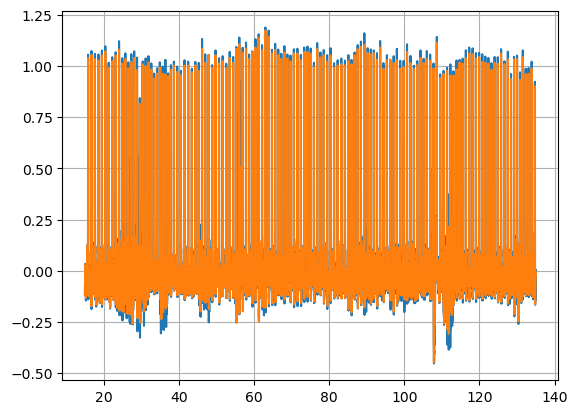

In [7]:
#plot
ecg.p.plot()
ecg_filtered.p.plot()

### 2.2 Specialized algorithms
Estimators are algorithms which aim at extracting the information of interest from the input signal, thus returning a new signal which has a different *"type"*. 

The name *`Estimators`* recalls the fact that the information extraction depends on the value of the algorithm parameters which might not be known *a-priori*. Thus the result should be considered as an estimate of the real content of information of the input signal.

In [9]:
# create an Estimator
import pyphysio.specialized.heart as heart

ibi_ecg = heart.BeatFromECG()

In [10]:
# check parameters
ibi_ecg

BeatFromECG{'bpm_max': 120, 'delta': 0, 'k': 0.7}

In [11]:
# apply an Estimator
ibi = ibi_ecg(ecg)

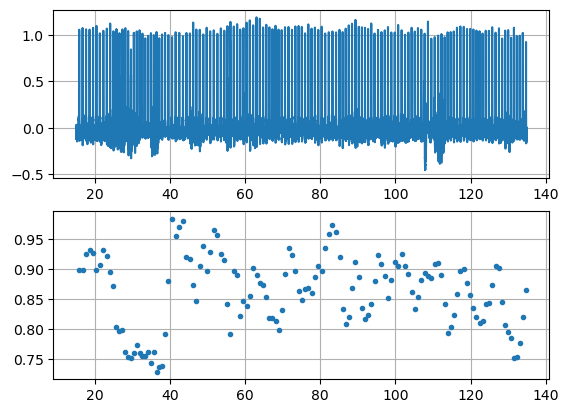

In [12]:
# plot
ax1 = plt.subplot(211)
ecg.p.plot()

plt.subplot(212, sharex=ax1)
ibi.p.plot('.')

### 2.3 Indicators

Indicators are algorithm which extract a metrics (scalar value) from the input signal, for instance a statistic (average).

Three types of indicators are provided in **`pyphysio`**:
* Time domain indicators: comprising simple statistical indicators and other metrics that can be computed on the signal values;
* Frequency domain indicators: metrics that are computed on the Power Spectrum Density (PSD) of the signal;
* Non-linear indicators: complex indicators that are computed on the signal values (e.g. Entropy).

TODO explain windowing

In [13]:
# create an Indicator
import pyphysio.indicators.timedomain as td_ind

rmssd = td_ind.RMSSD()
# check parameters
print(rmssd)

RMSSD{}


In [14]:
# apply an Indicator
rmssd_ = rmssd(ibi.dropna('time'))
print(rmssd_)

<xarray.Dataset>
Dimensions:                   (time: 139, channel: 1, component: 1)
Coordinates:
  * time                      (time) float64 15.85 16.75 17.67 ... 133.9 134.8
  * channel                   (channel) int64 0
  * component                 (component) int64 0
    time_start                (time) float64 15.85 nan nan nan ... nan nan nan
    time_stop                 (time) float64 134.8 nan nan nan ... nan nan nan
Data variables:
    signal                    (time, channel, component) float64 1.055 ... 0.923
    signal_BeatFromECG        (time, channel, component) float64 0.8989 ... 0...
    signal_BeatFromECG_RMSSD  (time, channel, component) float64 0.03261 ... nan
Attributes:
    MAIN:     signal_BeatFromECG_RMSSD
    history:  ['signal', 'BeatFromECG', 'RMSSD']


In [17]:
import pyphysio.indicators.frequencydomain as fd_ind

HF = fd_ind.PowerInBand(freq_max=0.4, freq_min=0.15, method = 'welch')

In [18]:
ibi_ = ibi.dropna('time').p.resample(4) #resampling is needed to compute the Power Spectrum Density
HF_ = HF(ibi_) 
print(HF_)

<xarray.Dataset>
Dimensions:                         (channel: 1, component: 1, time: 476)
Coordinates:
  * channel                         (channel) int64 0
  * component                       (component) int64 0
  * time                            (time) float64 15.85 16.1 ... 134.3 134.6
    time_start                      (time) float64 15.85 nan nan ... nan nan nan
    time_stop                       (time) float64 134.6 nan nan ... nan nan nan
Data variables:
    signal                          (time, channel, component) float64 1.055 ...
    signal_BeatFromECG              (time, channel, component) float64 0.8989...
    signal_BeatFromECG_PowerInBand  (time, channel, component) float64 0.0011...
Attributes:
    MAIN:     signal_BeatFromECG_PowerInBand
    history:  ['signal', 'BeatFromECG', 'PowerInBand']


### 2.4 Signal Quality Indicators

_TODO_

### 2.5 Utils

This is a collection of useful algorithms that can be used for signal processing. 

These algorithms might return scalar values or numpy arrays.

In [19]:
# create a Tool
import pyphysio.utils as utils

compute_psd = utils.PSD(method='welch', interp_freq = 4)

In [20]:
# check parameters
compute_psd

PSD{'method': 'welch', 'nfft': 2048, 'window': 'hamming', 'min_order': 10, 'max_order': 30, 'remove_mean': True, 'scaling': 'density', 'interp_freq': 4}

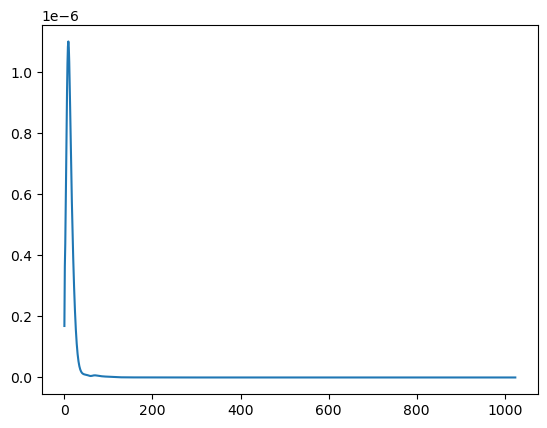

In [21]:
# apply a Tool
power = compute_psd(ecg)

plt.plot(power.coords['freq'], power.p.get_values().ravel())
plt.show()